C:\Users\user\AppData\Local\Temp\ipykernel_14616\3706563924.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model loaded.
Breed: Abyssinian


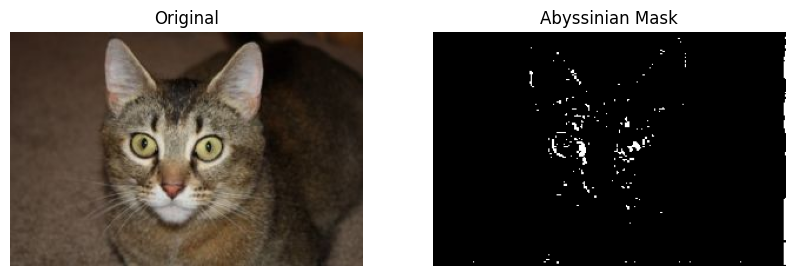

Breed: American Bobtail


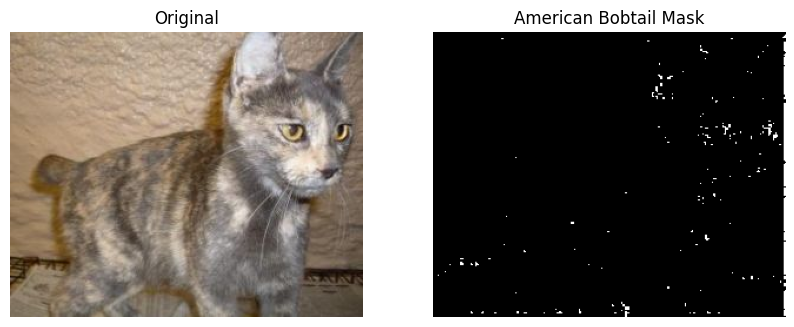

Breed: American Shorthair


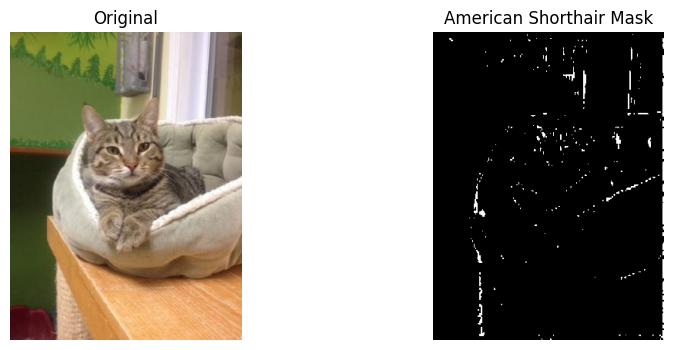

Breed: Bengal


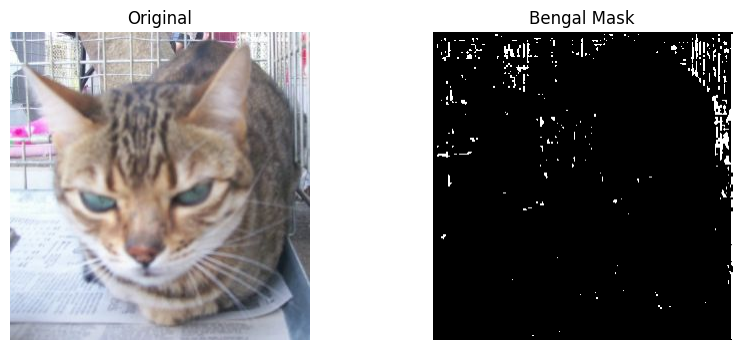

Breed: Birman


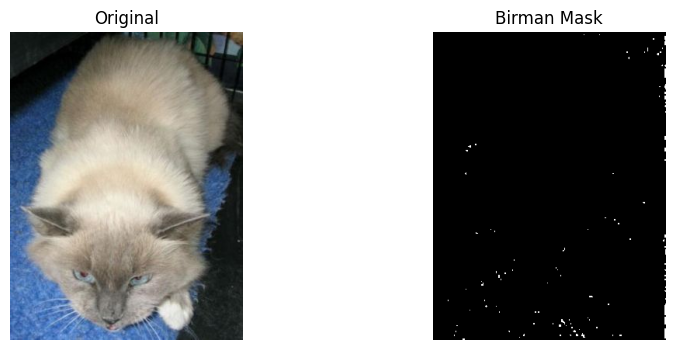

Breed: Bombay


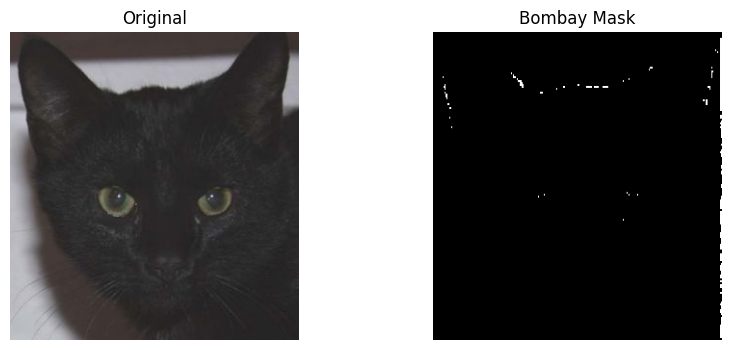

Breed: British Shorthair


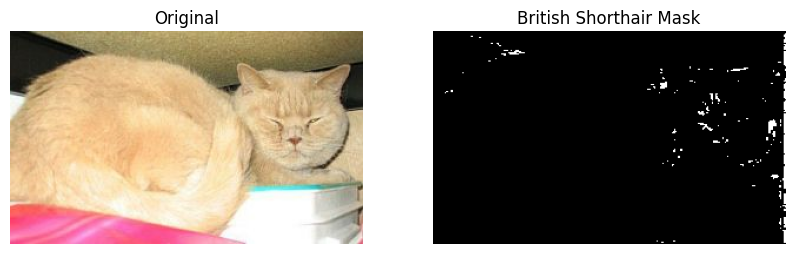

Breed: Egyptian Mau


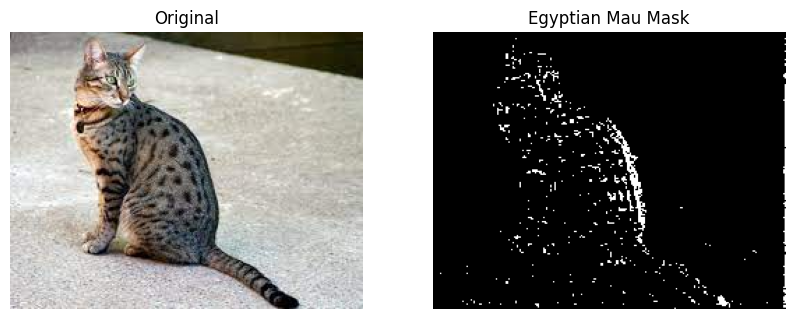

Breed: Maine Coon


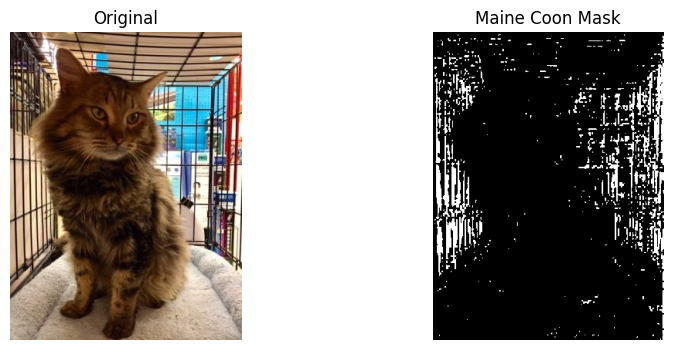

Breed: Persian


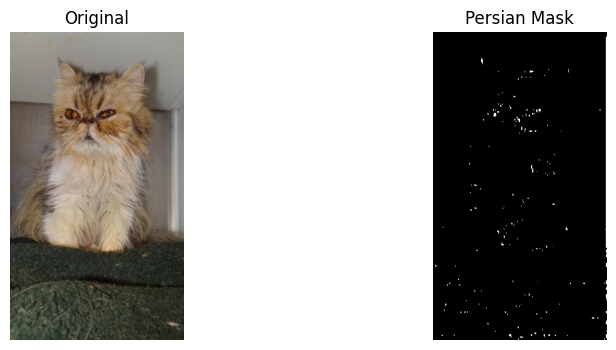

Breed: Ragdoll


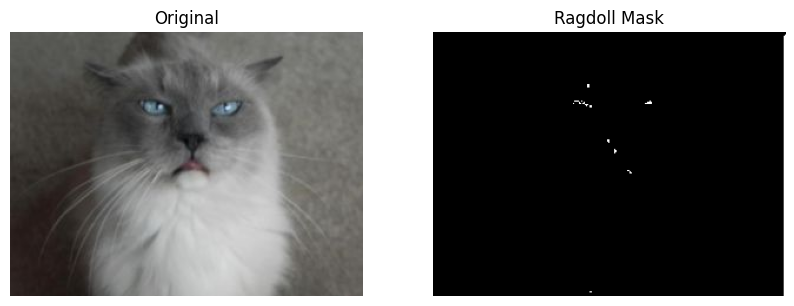

Breed: Russian Blue


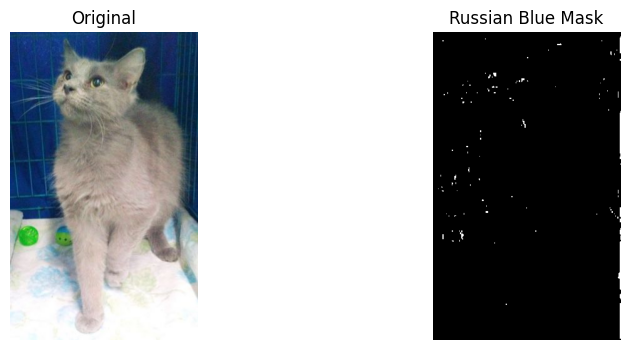

Breed: Siamese


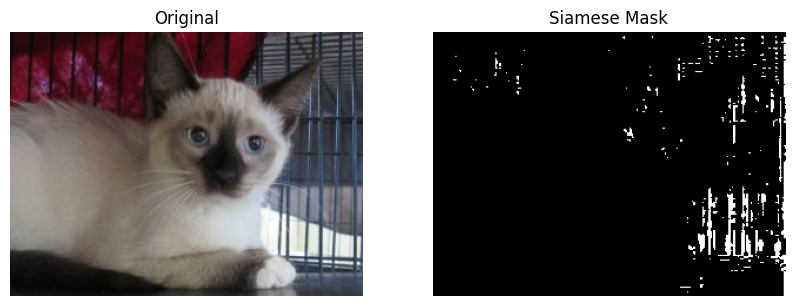

Breed: Sphynx


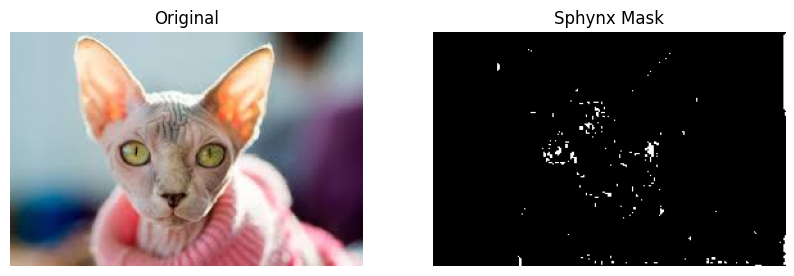

Breed: Tuxedo


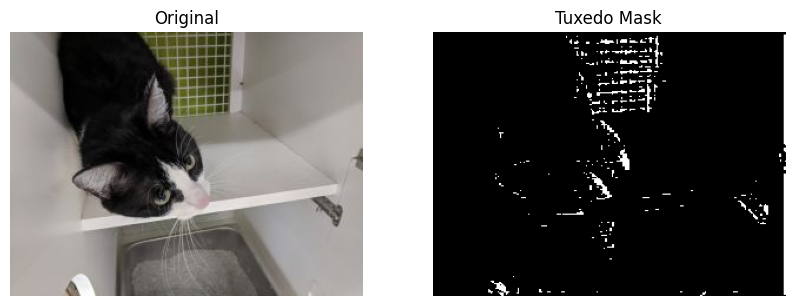

'\nOUTPUT_DIR = "segmentation_masks"\nos.makedirs(OUTPUT_DIR, exist_ok=True)\n\nfor breed_path in breed_dirs:\n    breed_name = os.path.basename(breed_path)\n    out_breed = os.path.join(OUTPUT_DIR, breed_name)\n    os.makedirs(out_breed, exist_ok=True)\n\n    images = [\n        f for f in os.listdir(breed_path)\n        if f.lower().endswith((\'.jpg\', \'.jpeg\', \'.png\'))\n    ]\n\n    for img_name in images:\n        img_path = os.path.join(breed_path, img_name)\n        img = Image.open(img_path).convert("RGB")\n        img_np = np.array(img)\n\n        mask = run_segmentation(img_np)\n        mask_img = Image.fromarray((mask * 255).astype(np.uint8))\n\n        out_path = os.path.join(out_breed, img_name + "_mask.png")\n        mask_img.save(out_path)\n\nprint("All masks saved.")\n'

In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Build UNet with MobileNetV2 encoder (pretrained)
# ---------------------------------------------------------
def build_unet(input_shape=(320, 320, 3)):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Encoder layers
    skips = [
        base_model.get_layer("block_1_expand_relu").output, 
        base_model.get_layer("block_3_expand_relu").output,
        base_model.get_layer("block_6_expand_relu").output,
        base_model.get_layer("block_13_expand_relu").output
    ]

    encoder_output = base_model.get_layer("block_16_project").output

    # Decoder (U-Net style)
    x = encoder_output

    decoder_filters = [512, 256, 128, 64]
    for f, skip in zip(decoder_filters, reversed(skips)):
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        x = tf.keras.layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = tf.keras.layers.Conv2D(f, 3, padding="same", activation="relu")(x)

    # Final mask output
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    return model


# ---------------------------------------------------------
# Initialize model
# ---------------------------------------------------------
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy')  # placeholder loss
print("Model loaded.")


# ---------------------------------------------------------
# Segmentation inference
# ---------------------------------------------------------
def run_segmentation(img):
    h, w, _ = img.shape

    inp = tf.image.resize(img, (320, 320))
    inp = inp / 255.0
    inp = tf.expand_dims(inp, 0)

    pred = model.predict(inp, verbose=0)[0]
    pred = tf.image.resize(pred, (h, w)).numpy()
    mask = (pred > 0.5).astype(np.uint8)
    return mask[:, :, 0]


# ---------------------------------------------------------
# Visualization
# ---------------------------------------------------------
def visualize_pair(img, mask, title="Segmentation"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()


# ---------------------------------------------------------
# Dataset root
# ---------------------------------------------------------
DATASET_ROOT = "Gano-Cat-Breeds-V1_1"

breed_dirs = sorted([
    os.path.join(DATASET_ROOT, d)
    for d in os.listdir(DATASET_ROOT)
    if os.path.isdir(os.path.join(DATASET_ROOT, d))
])


# ---------------------------------------------------------
# Show first image per breed
# ---------------------------------------------------------
for breed_path in breed_dirs:
    breed_name = os.path.basename(breed_path)

    images = [f for f in os.listdir(breed_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not images:
        print(f"No images for breed: {breed_name}")
        continue

    img_path = os.path.join(breed_path, images[0])
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    mask = run_segmentation(img_np)

    print(f"Breed: {breed_name}")
    visualize_pair(img_np, mask, title=f"{breed_name} Mask")


# ---------------------------------------------------------
# OPTIONAL – Save masks for all images (commented)
# ---------------------------------------------------------
"""
OUTPUT_DIR = "segmentation_masks"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for breed_path in breed_dirs:
    breed_name = os.path.basename(breed_path)
    out_breed = os.path.join(OUTPUT_DIR, breed_name)
    os.makedirs(out_breed, exist_ok=True)

    images = [
        f for f in os.listdir(breed_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    for img_name in images:
        img_path = os.path.join(breed_path, img_name)
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        mask = run_segmentation(img_np)
        mask_img = Image.fromarray((mask * 255).astype(np.uint8))

        out_path = os.path.join(out_breed, img_name + "_mask.png")
        mask_img.save(out_path)

print("All masks saved.")
"""
